### Classification of FR abstracts as big data or not.

Uses Doc2Vec as vectorization and current labeled dataset of 1600 abstracts.

In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report, confusion_matrix

pd.set_option('display.max_columns', 50)

#### Ingest Data - labeled set and full corpus

In [2]:
# read in new training dataset - 1600 labeled abstracts
df_lab = pd.read_csv("../../../../data/prd/Digital_abstract_labelled/DEC-2022-labelled_abstracts.csv")
print(df_lab.shape)
df_lab.head()

(1600, 8)


,Unnamed: 0,Duplicates,index,PROJECT_ID,ABSTRACT,Is it related to Big-Data,Expert name,label
0,0,0,979,950056,ï»¿ DESCRIPTION (provided by applicant): Adv...,1,Kristian,Big-data
1,1,0,816,1178172,Project Summary/AbstractThe establishment of t...,1,Kristian,Big-data
2,2,0,1096,163037,DESCRIPTION (provided by applicant): The long-...,0,Kristian,Non Big-data
3,3,0,725,880197,DESCRIPTION (provided by applicant): The most ...,0,Kristian,Non Big-data
4,4,0,92,887331,Transsphenoidal surgery (TSS) is the best trea...,0,Kristian,Non Big-data


In [3]:
df_lab = df_lab[['PROJECT_ID','ABSTRACT','Is it related to Big-Data','label']]
df_lab.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label
0,950056,ï»¿ DESCRIPTION (provided by applicant): Adv...,1,Big-data
1,1178172,Project Summary/AbstractThe establishment of t...,1,Big-data
2,163037,DESCRIPTION (provided by applicant): The long-...,0,Non Big-data
3,880197,DESCRIPTION (provided by applicant): The most ...,0,Non Big-data
4,887331,Transsphenoidal surgery (TSS) is the best trea...,0,Non Big-data


In [4]:
#data frame with all of the abstracts
df = pd.read_pickle("../../../../data/prd/Paper/FR_meta_and_final_tokens_23DEC21.pkl")

# Reset the df index and create a variable index to link with PROJECT_ID
df.reset_index(inplace = True, drop = True)
print(df.shape)
df.head()

(1143869, 30)


,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...


In [5]:
df = df[['PROJECT_ID','ABSTRACT']]
df.head()

,PROJECT_ID,ABSTRACT
0,89996,"This is a project to explore Game-based, Metap..."
1,89997,Institution: Franklin Institute Science Museum...
2,89998,Through programs (including small group conver...
3,89999,In partnership with the American Chemical Soci...
4,90001,The Center for Molecular Interfacing (CMI) wil...


In [6]:
# merge with the labelled data using PROJECT_ID.
df['PROJECT_ID'] = pd.to_numeric(df['PROJECT_ID'])
df_merge = df.merge(df_lab[['PROJECT_ID','Is it related to Big-Data','label']], how='left', on='PROJECT_ID')
len(df_merge)

1143869

In [7]:
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN
2,89998,Through programs (including small group conver...,NaN,NaN
3,89999,In partnership with the American Chemical Soci...,NaN,NaN
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN


In [8]:
# Save project ID of labelled data
project_id_lab = list(df_lab['PROJECT_ID'])

# Get the index of labelled abstract
subset_df = df_merge.loc[df_merge['PROJECT_ID'].isin(project_id_lab),['PROJECT_ID','label']]

In [9]:
subset_df.head()

,PROJECT_ID,label
373,90145,Big-data
672,90761,Big-data
1050,91187,Non Big-data
1387,91282,Non Big-data
1413,91311,Non Big-data


In [10]:
# build training and testing sets from the labeled data 
# sklearn to find list of indices for training and test set

X_train_idx, X_test_idx, y_train_doc2vec, y_test_doc2vec = train_test_split(subset_df.index, 
                                                                        subset_df['label'].values, 
                                                                        test_size=0.20, random_state=0, 
                                                                        stratify=subset_df['label'].values)


# 1. Doc2Vec approach

## 1.1. Vectorize, build the training and test sample

In [9]:
# tagging and saving data (do not need to run this again - data is saved in tagged_df.csv)

#tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(df['ABSTRACT'])]
#tagged_df = pd.DataFrame(tagged_data)
#tagged_df.to_csv('tagged_df.csv')

In [12]:
# Create the Doc2Vec model and train using labelled data (do not need to run this again - model saved in d2v.model)

#model = gensim.models.doc2vec.Doc2Vec(vector_size=100, epochs=100) #min_count=2 - min number of times it shows up
#model.build_vocab(tagged_data)
#model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
#model.save("d2v.model")

In [11]:
# Load the Doc2Vec model
model = Doc2Vec.load("../../../../data/prd/Doc2Vec/d2v.model")

In [12]:
# Get document representations from the model results - list of lists.  
vector = []
for i in range(0, len(df)):
    vectorthis = (model.dv[i]).tolist()
    vector.append(vectorthis)

In [13]:
# doc representations - each row is a document representation
doc_reps = pd.DataFrame(vector)
print(doc_reps.shape)
doc_reps.head()

(1143869, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.982922,2.319988,3.742522,0.944506,-1.694736,-3.728322,0.204749,-1.112957,1.098760,-4.612341,0.733703,-2.214583,-0.259219,-0.214456,0.995408,-1.186774,-0.131439,-1.180803,1.841610,-1.639843,-2.358011,3.413001,3.731894,1.390462,3.263571,...,-1.041995,2.063597,0.650890,-0.009327,-2.202883,-0.411864,-1.595071,-1.730732,-1.397346,-0.712966,1.295766,-1.123551,-0.102224,2.066787,0.765735,4.270835,3.079768,-0.978548,0.275256,0.677612,-2.733896,0.354953,-1.033716,0.140886,-2.464530
1,0.456848,-0.227907,-0.991774,2.260244,-1.303596,-1.987082,-2.183362,1.811930,-0.897663,0.843100,0.932140,-4.361772,-0.521623,0.296213,1.349446,-0.805430,-1.736138,-0.538803,0.459269,-0.474585,-2.454310,1.329033,2.992836,1.203448,0.310803,...,1.549266,-1.570076,-1.332427,-0.770249,1.699491,-0.274130,-5.603177,-1.300055,-0.810193,-2.107439,0.174144,2.185729,-2.083795,2.886135,-0.271330,3.001608,2.179992,3.509960,0.711321,-0.808178,-1.946631,-0.329511,-1.518070,1.803749,-0.085112
2,3.939317,-0.077519,1.721057,-0.717855,-3.445618,-2.466907,-0.437651,3.141626,-3.202489,0.375526,0.532302,-1.165914,-0.406458,0.446012,-1.526703,-0.200713,1.268217,0.085013,-0.847399,0.953084,0.618521,2.339281,-1.306460,0.514830,2.718282,...,0.788696,1.818320,-1.556971,1.819863,1.508475,-1.179790,0.828222,0.005567,-0.094424,-0.004659,-0.880713,-0.720786,1.472627,-1.323683,3.885650,1.376774,-0.988943,0.242667,-1.518137,-0.670374,-1.113849,-0.119800,-4.312647,-0.575666,-0.374445
3,0.261933,2.833923,-1.429265,2.710543,-2.051509,-2.664451,1.328356,0.693114,-2.763685,1.123290,-1.326368,-1.178106,2.254581,2.241744,0.068839,1.155099,1.886543,-2.059903,-1.559700,-0.770142,-0.253473,-0.482159,0.112768,-0.993233,-0.440269,...,-0.095776,0.772124,-0.252873,-0.083401,-1.206205,-0.901444,1.999393,0.931728,-1.386474,-1.996466,-2.597653,-1.525401,-1.121509,0.461437,-0.235091,2.322187,-1.351750,0.528141,-2.293975,-0.394241,-1.240165,0.156464,-0.477509,0.817239,0.814438
4,1.591960,1.018378,-0.159254,1.763578,-1.124414,-0.417599,-1.689906,0.896199,-0.812358,-0.964306,-1.619780,0.353326,2.982134,1.652212,0.084070,-2.297758,-0.385808,-2.790571,2.477949,0.223171,0.887371,1.535304,0.736297,-0.550977,3.002540,...,-0.894851,2.199989,-2.327350,0.552252,0.862642,-0.526882,2.033086,0.602459,0.172678,-1.177264,-2.423429,1.038152,-1.498387,-1.542013,0.237539,-2.691047,-1.320943,1.387134,1.664728,-0.789113,-0.246745,2.204133,-1.852782,-2.572883,2.798885


In [14]:
# convert to numpy array
doc_reps_np = doc_reps.to_numpy()

In [15]:
# Create feature train and test sets from the Doc2Vec matrix

X_train_doc2vec = doc_reps_np[X_train_idx] 
X_test_doc2vec = doc_reps_np[X_test_idx]

## 1.2. KNN classifier

In [16]:
# number of neighbors
k = int(math.sqrt(len(y_train_doc2vec)))
print('Number of neighbors:', k)

Number of neighbors: 35


In [17]:
# Run KNN

classifierKNN = KNeighborsClassifier(n_neighbors= k)  # njobs? don't need

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifierKNN, X_train_doc2vec, y_train_doc2vec, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
classifierKNN.fit(X_train_doc2vec, y_train_doc2vec)

# find model accuracy
classifierKNN.score(X_test_doc2vec,y_test_doc2vec)

[0.76953125 0.77734375 0.7265625  0.7890625  0.76953125]
Accuracy: 0.77.   Standard Deviation: 0.02


0.778125

In [18]:
# Predict the classification
y_pred_doc2vec = classifierKNN.predict(X_test_doc2vec)

In [19]:
# Classifier performance
confusion = confusion_matrix(y_test_doc2vec, y_pred_doc2vec)
print(confusion)
print(classification_report(y_test_doc2vec, y_pred_doc2vec))

[[ 87  50]
 [ 21 162]]
              precision    recall  f1-score   support

    Big-data       0.81      0.64      0.71       137
Non Big-data       0.76      0.89      0.82       183

    accuracy                           0.78       320
   macro avg       0.78      0.76      0.77       320
weighted avg       0.78      0.78      0.77       320



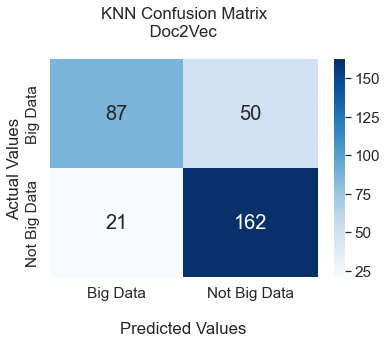

In [20]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('KNN Confusion Matrix\n Doc2Vec \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/doc2vec_KNN.png', bbox_inches='tight')
plt.show()

In [21]:
# Predict the classification for the whole data
t1 = time.time()
y_doc2vec = classifierKNN.predict(vector)
t2 = time.time()

print(t2-t1)

244.694815158844


In [22]:
# The vector keeps the order from index. Just add the prediction as new variable
df_merge['Prediction_KNN'] = y_doc2vec
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Non Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Non Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Non Big-data


## 1.3. SVM

In [23]:
# We run SVM with default parameters provides by Sklearn. We train the model

classifier_svm = svm.SVC()

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifier_svm, X_train_doc2vec, y_train_doc2vec, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
classifier_svm.fit(X_train_doc2vec, y_train_doc2vec)

# find model accuracy
classifier_svm.score(X_test_doc2vec,y_test_doc2vec)

[0.78125    0.8359375  0.80078125 0.80078125 0.78125   ]
Accuracy: 0.80.   Standard Deviation: 0.02


0.815625

In [24]:
# Predict the classification
y_pred_doc2vec = classifier_svm.predict(X_test_doc2vec)

In [25]:
# Classifier performance
confusion = confusion_matrix(y_test_doc2vec, y_pred_doc2vec)
print(confusion)
print(classification_report(y_test_doc2vec, y_pred_doc2vec))

[[108  29]
 [ 30 153]]
              precision    recall  f1-score   support

    Big-data       0.78      0.79      0.79       137
Non Big-data       0.84      0.84      0.84       183

    accuracy                           0.82       320
   macro avg       0.81      0.81      0.81       320
weighted avg       0.82      0.82      0.82       320



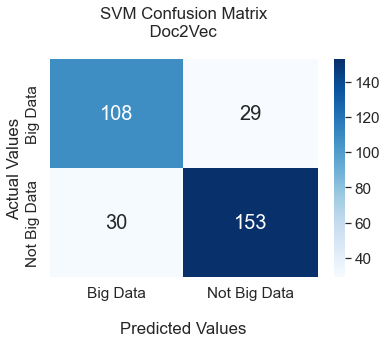

In [26]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('SVM Confusion Matrix\n Doc2Vec \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/doc2vec_SVM.png', bbox_inches='tight')
plt.show()

In [27]:
# Predict the classification for the whole data
t1 = time.time()
y_doc2vec = classifier_svm.predict(vector)
t2 = time.time()

print(t2-t1)

124.16285419464111


In [28]:
# The vector keeps the order from index. Just add the prediction as new variable
df_merge['Prediction_SVM'] = y_doc2vec
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Non Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Non Big-data,Non Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Non Big-data,Non Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Non Big-data,Non Big-data


## 1.4. Decision Tree

In [29]:
# Use default parameters provides by SKLearn and train the model
classifier_DT = DecisionTreeClassifier(random_state = 0)

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifier_DT, X_train_doc2vec, y_train_doc2vec, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
classifier_DT.fit(X_train_doc2vec, y_train_doc2vec)

# find model accuracy
classifier_DT.score(X_test_doc2vec,y_test_doc2vec)

[0.6484375  0.67578125 0.62890625 0.609375   0.625     ]
Accuracy: 0.64.   Standard Deviation: 0.02


0.6375

In [30]:
# Predict the classification
y_pred_doc2vec = classifier_DT.predict(X_test_doc2vec)

In [31]:
# Classifier performance
confusion = confusion_matrix(y_test_doc2vec, y_pred_doc2vec)
print(confusion)
print(classification_report(y_test_doc2vec, y_pred_doc2vec))

[[ 83  54]
 [ 62 121]]
              precision    recall  f1-score   support

    Big-data       0.57      0.61      0.59       137
Non Big-data       0.69      0.66      0.68       183

    accuracy                           0.64       320
   macro avg       0.63      0.63      0.63       320
weighted avg       0.64      0.64      0.64       320



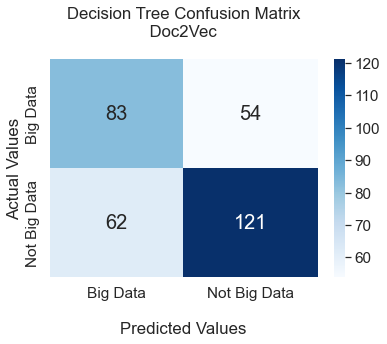

In [32]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('Decision Tree Confusion Matrix\n Doc2Vec \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/doc2vec_DT.png', bbox_inches='tight')
plt.show()

In [33]:
# Predict the classification for the whole data
t1 = time.time()
y_doc2vec = classifier_DT.predict(vector)
t2 = time.time()

print(t2-t1)

5.683920383453369


In [34]:
# The vector keeps the order from index. Just add the prediction as new variable
df_merge['Prediction_DT'] = y_doc2vec
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM,Prediction_DT
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Non Big-data,Non Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Non Big-data,Non Big-data,Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Non Big-data,Non Big-data,Big-data


## 1.5. Random Forest

In [35]:
# Use default parameters provides by SKLearn and train the model
classifier_RF = RandomForestClassifier(random_state=0)  # use njobs?

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifier_RF, X_train_doc2vec, y_train_doc2vec, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
classifier_RF.fit(X_train_doc2vec, y_train_doc2vec)

# find model accuracy
classifier_RF.score(X_test_doc2vec,y_test_doc2vec)

[0.77734375 0.828125   0.7734375  0.8046875  0.765625  ]
Accuracy: 0.79.   Standard Deviation: 0.02


0.828125

In [36]:
# Predict the classification
y_pred_doc2vec = classifier_RF.predict(X_test_doc2vec)

In [37]:
# Classifier performance
confusion = confusion_matrix(y_test_doc2vec, y_pred_doc2vec)
print(confusion)
print(classification_report(y_test_doc2vec, y_pred_doc2vec))

[[105  32]
 [ 23 160]]
              precision    recall  f1-score   support

    Big-data       0.82      0.77      0.79       137
Non Big-data       0.83      0.87      0.85       183

    accuracy                           0.83       320
   macro avg       0.83      0.82      0.82       320
weighted avg       0.83      0.83      0.83       320



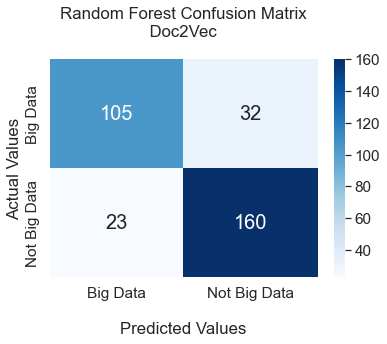

In [38]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('Random Forest Confusion Matrix\n Doc2Vec \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/doc2vec_RF.png', bbox_inches='tight')
plt.show()

In [39]:
# Predict the classification for the whole data
t1 = time.time()
y_doc2vec = classifier_RF.predict(vector)
t2 = time.time()

print(t2-t1)

15.670320987701416


In [40]:
# The vector keeps the order from index. Just add the prediction as new variable
df_merge['Prediction_RF'] = y_doc2vec
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM,Prediction_DT,Prediction_RF
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Non Big-data,Non Big-data,Big-data,Non Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Non Big-data,Non Big-data,Big-data,Non Big-data


## 1.6. Neural network classifier

In [41]:
# Use default parameters provides by SKLearn and train the model
classifier_nn = MLPClassifier(random_state=0, verbose=True)

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifier_nn, X_train_doc2vec, y_train_doc2vec, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
t1 = time.time()
classifier_nn.fit(X_train_doc2vec, y_train_doc2vec)
t2 = time.time()

print(t2-t1)

# find model accuracy
classifier_nn.score(X_test_doc2vec,y_test_doc2vec)

Iteration 1, loss = 0.74485672
Iteration 2, loss = 0.58729261
Iteration 3, loss = 0.49973111
Iteration 4, loss = 0.45341155
Iteration 5, loss = 0.42274546
Iteration 6, loss = 0.40001438
Iteration 7, loss = 0.38325290
Iteration 8, loss = 0.36814110
Iteration 9, loss = 0.35295273
Iteration 10, loss = 0.34356303
Iteration 11, loss = 0.33236733
Iteration 12, loss = 0.32067085
Iteration 13, loss = 0.31112274
Iteration 14, loss = 0.30194929
Iteration 15, loss = 0.29232903
Iteration 16, loss = 0.28361499
Iteration 17, loss = 0.27545228
Iteration 18, loss = 0.26777711
Iteration 19, loss = 0.26012685
Iteration 20, loss = 0.25243420
Iteration 21, loss = 0.24727335
Iteration 22, loss = 0.23801074
Iteration 23, loss = 0.23092820
Iteration 24, loss = 0.22322957
Iteration 25, loss = 0.21732046
Iteration 26, loss = 0.21035277
Iteration 27, loss = 0.20304003
Iteration 28, loss = 0.19662283
Iteration 29, loss = 0.19083346
Iteration 30, loss = 0.18687534
Iteration 31, loss = 0.17942372
Iteration 32, los

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 18, loss = 0.26475323
Iteration 19, loss = 0.25499787
Iteration 20, loss = 0.24804934
Iteration 21, loss = 0.24143912
Iteration 22, loss = 0.23461205
Iteration 23, loss = 0.22648884
Iteration 24, loss = 0.22081225
Iteration 25, loss = 0.21417968
Iteration 26, loss = 0.21127584
Iteration 27, loss = 0.20565935
Iteration 28, loss = 0.19516008
Iteration 29, loss = 0.19177139
Iteration 30, loss = 0.18402098
Iteration 31, loss = 0.17974513
Iteration 32, loss = 0.17317075
Iteration 33, loss = 0.16855400
Iteration 34, loss = 0.16288918
Iteration 35, loss = 0.15728945
Iteration 36, loss = 0.15202672
Iteration 37, loss = 0.14770794
Iteration 38, loss = 0.14264730
Iteration 39, loss = 0.13837393
Iteration 40, loss = 0.13400218
Iteration 41, loss = 0.12929343
Iteration 42, loss = 0.12609622
Iteration 43, loss = 0.12245683
Iteration 44, loss = 0.11818535
Iteration 45, loss = 0.11457736
Iteration 46, loss = 0.11024390
Iteration 47, loss = 0.10684659
Iteration 48, loss = 0.10376131
Iteratio

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.37965262
Iteration 8, loss = 0.36298623
Iteration 9, loss = 0.34874699
Iteration 10, loss = 0.33858638
Iteration 11, loss = 0.32502332
Iteration 12, loss = 0.31688426
Iteration 13, loss = 0.30448902
Iteration 14, loss = 0.29710578
Iteration 15, loss = 0.28855684
Iteration 16, loss = 0.27974380
Iteration 17, loss = 0.27252664
Iteration 18, loss = 0.26513095
Iteration 19, loss = 0.25727757
Iteration 20, loss = 0.25080064
Iteration 21, loss = 0.24351814
Iteration 22, loss = 0.23775685
Iteration 23, loss = 0.23066300
Iteration 24, loss = 0.22369319
Iteration 25, loss = 0.21589710
Iteration 26, loss = 0.21093859
Iteration 27, loss = 0.20311443
Iteration 28, loss = 0.19960592
Iteration 29, loss = 0.19197457
Iteration 30, loss = 0.18923075
Iteration 31, loss = 0.18137904
Iteration 32, loss = 0.17920746
Iteration 33, loss = 0.17131567
Iteration 34, loss = 0.16654372
Iteration 35, loss = 0.16093683
Iteration 36, loss = 0.15610919
Iteration 37, loss = 0.15177483
Iteration 3

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 19, loss = 0.26555652
Iteration 20, loss = 0.25675350
Iteration 21, loss = 0.25401325
Iteration 22, loss = 0.24473383
Iteration 23, loss = 0.24020029
Iteration 24, loss = 0.23119410
Iteration 25, loss = 0.22447898
Iteration 26, loss = 0.21763401
Iteration 27, loss = 0.21137143
Iteration 28, loss = 0.20469386
Iteration 29, loss = 0.19959161
Iteration 30, loss = 0.19370431
Iteration 31, loss = 0.18863344
Iteration 32, loss = 0.18293877
Iteration 33, loss = 0.17668484
Iteration 34, loss = 0.17087217
Iteration 35, loss = 0.16533162
Iteration 36, loss = 0.16076652
Iteration 37, loss = 0.15780694
Iteration 38, loss = 0.15136404
Iteration 39, loss = 0.14753334
Iteration 40, loss = 0.14249467
Iteration 41, loss = 0.13708891
Iteration 42, loss = 0.13207769
Iteration 43, loss = 0.12782768
Iteration 44, loss = 0.12464209
Iteration 45, loss = 0.12043151
Iteration 46, loss = 0.11591276
Iteration 47, loss = 0.11197188
Iteration 48, loss = 0.10866574
Iteration 49, loss = 0.10565688
Iteratio

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.36695700
Iteration 8, loss = 0.35061166
Iteration 9, loss = 0.33800010
Iteration 10, loss = 0.32519284
Iteration 11, loss = 0.31447934
Iteration 12, loss = 0.30507007
Iteration 13, loss = 0.29371047
Iteration 14, loss = 0.28445827
Iteration 15, loss = 0.27483084
Iteration 16, loss = 0.26569192
Iteration 17, loss = 0.25724460
Iteration 18, loss = 0.24859636
Iteration 19, loss = 0.24009121
Iteration 20, loss = 0.23250425
Iteration 21, loss = 0.22373076
Iteration 22, loss = 0.21533803
Iteration 23, loss = 0.20825281
Iteration 24, loss = 0.20016968
Iteration 25, loss = 0.19341856
Iteration 26, loss = 0.18557970
Iteration 27, loss = 0.17833157
Iteration 28, loss = 0.17134106
Iteration 29, loss = 0.16466947
Iteration 30, loss = 0.15788697
Iteration 31, loss = 0.15156109
Iteration 32, loss = 0.14544231
Iteration 33, loss = 0.13979603
Iteration 34, loss = 0.13350147
Iteration 35, loss = 0.12812700
Iteration 36, loss = 0.12243761
Iteration 37, loss = 0.11698196
Iteration 3

0.803125

In [42]:
# Predict the classification
y_pred_doc2vec = classifier_nn.predict(X_test_doc2vec)

In [43]:
# Classifier performance
confusion = confusion_matrix(y_test_doc2vec, y_pred_doc2vec)
print(confusion)
print(classification_report(y_test_doc2vec, y_pred_doc2vec))

[[112  25]
 [ 38 145]]
              precision    recall  f1-score   support

    Big-data       0.75      0.82      0.78       137
Non Big-data       0.85      0.79      0.82       183

    accuracy                           0.80       320
   macro avg       0.80      0.80      0.80       320
weighted avg       0.81      0.80      0.80       320



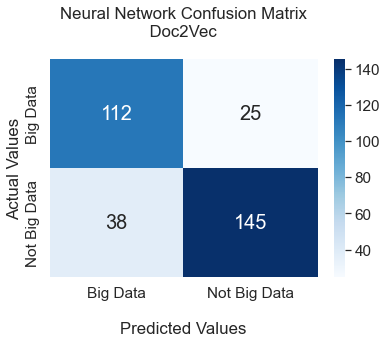

In [44]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('Neural Network Confusion Matrix\n Doc2Vec \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/doc2vec_NN.png', bbox_inches='tight')
plt.show()

In [45]:
# Predict the classification for the whole data
t1 = time.time()
y_doc2vec = classifier_nn.predict(vector)
t2 = time.time()

print(t2-t1)

6.760635137557983


In [46]:
# The vector keeps the order from index. Just add the prediction as new variable
df_merge['Prediction_NN'] = y_doc2vec
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM,Prediction_DT,Prediction_RF,Prediction_NN
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Non Big-data,Non Big-data,Big-data,Non Big-data,Non Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Non Big-data,Non Big-data,Big-data,Non Big-data,Non Big-data


In [47]:
# save classification results
df_merge.to_csv("/project/biocomplexity/sdad/projects_data/ncses/prd/Digital_abstract_labelled/big_data/doc2vec_new_training_set.csv")